# IMDB Movie Reviews Sentiment Analysis and Model Deployment with Flask

## What is Sentiment?

Sentiment analysis is the interpretation and classification of emotions within text data using text analysis techniques.
- Positive
- Neutral
- Negative



Sentiment analysis is a machine learning technique that detects polarity.

## How Sentiment is Detected from Text Data?

- Text cleaning is done
- Text data is converted into numerical data
- ML model is trained
- Test and Evaluate the model

# Preprocess the text data using custom package 

1. Download and install the package preprocess_kgptalkie
Command :  !pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git

2. import preprocess_kgptalkie

In [5]:
# !pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
import preprocess_kgptalkie as ps

In [4]:
df = pd.read_csv('imdb_reviews.txt', sep = '\t', header = None)

In [5]:
df.columns = ['reviews', 'sentiment']

In [6]:
df.head()

,reviews,sentiment
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [9]:
# Convert the contraction to expansions( abbrevations)
# For example : u - You
df['reviews'] = df['reviews'].apply(lambda x: ps.cont_exp(x))

# Remove all the characters that are not alphanumeric
# For example : we are winners! -> we are winners
df['reviews'] = df['reviews'].apply(lambda x: ps.remove_special_chars(x))

# Normalise characters which look identical actually are identical.
# For example :  ñ -> n 
df['reviews'] = df['reviews'].apply(lambda x: ps.remove_accented_chars(x))

# Used Regex to remove the emails
df['reviews'] = df['reviews'].apply(lambda x: ps.remove_emails(x))

# Used Beautiful Soap to remove the html tag
df['reviews'] = df['reviews'].apply(lambda x: ps.remove_html_tags(x))

# used Regex to remove url 
df['reviews'] = df['reviews'].apply(lambda x: ps.remove_urls(x))

# Lemmatise the words using token. lemma
df['reviews'] = df['reviews'].apply(lambda x: ps.make_base(x))


In [10]:
df['reviews'] = df['reviews'].apply(lambda x: str(x).lower())

In [85]:
df["sentiment"].value_counts()

1    384
0    360
Name: sentiment, dtype: int64

# Visualise the dataset

In [87]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas_profiling as pp
from PIL import Image
import seaborn as sns

In [16]:
df.profile_report()

In [19]:
df = df.drop_duplicates()

In [25]:
df.isnull().sum()

reviews      0
sentiment    0
dtype: int64

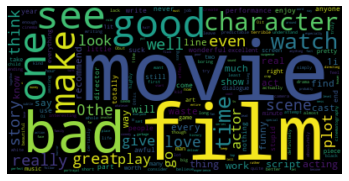

In [29]:
# Start with one review:
text = " ".join(reviews for reviews in df.reviews)

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [80]:
imdb = np.array(Image.open("imdb.png"))

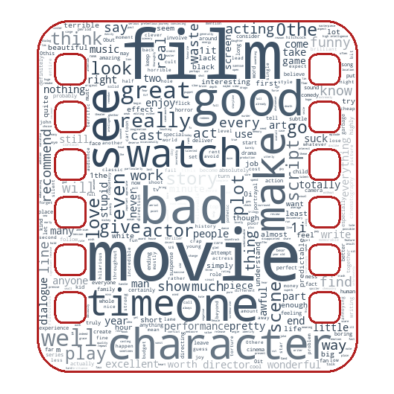

In [84]:
# Doinf some crazy visualisations to plot on image

wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=1000, mask=imdb,contour_width=3, contour_color='firebrick').generate(text)

# create coloring from image
image_colors = ImageColorGenerator(imdb)
plt.figure(figsize=[10,7])
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

# store to file
plt.savefig("imdb1.png", format="png")

plt.show()



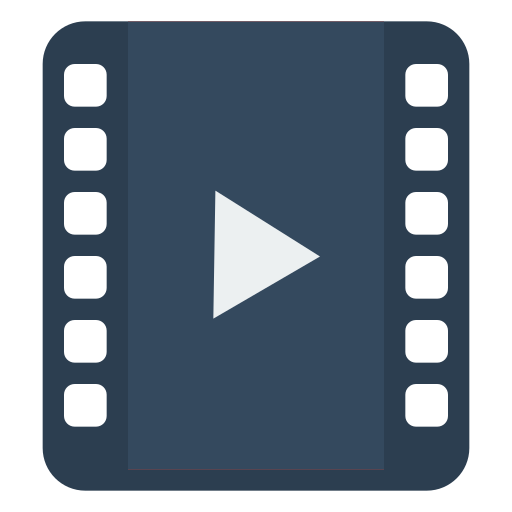

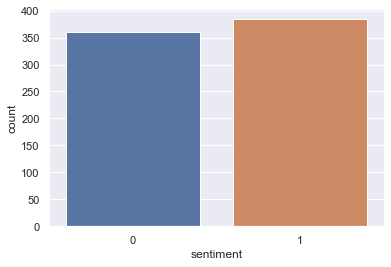

In [86]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="sentiment", data=df)

## Data Preparation for Model Training

In [88]:
X = df['reviews']
y = df['sentiment']

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [90]:
X_train.shape, X_test.shape

((595,), (149,))

## ML Model Building 

In [91]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(solver = 'liblinear'))
])

In [92]:
hyperparameters = {
    'tfidf__max_df': (0.5, 1.0),
    'tfidf__ngram_range': ((1,1), (1,2)),
    'tfidf__use_idf': (True, False),
    'tfidf__analyzer': ('word', 'char', 'char_wb'),
    'clf__penalty': ('l2', 'l1'),
    'clf__C': (1,2)
}

In [93]:
clf = GridSearchCV(pipe, hyperparameters, n_jobs=-1, cv = None)

In [94]:
%%time
clf.fit(X_train, y_train)

CPU times: user 737 ms, sys: 114 ms, total: 851 ms
Wall time: 6.09 s


GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf',
                                        LogisticRegression(solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'clf__C': (1, 2), 'clf__penalty': ('l2', 'l1'),
                         'tfidf__analyzer': ('word', 'char', 'char_wb'),
                         'tfidf__max_df': (0.5, 1.0),
                         'tfidf__ngram_range': ((1, 1), (1, 2)),
                         'tfidf__use_idf': (True, False)})

In [95]:
clf.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf', LogisticRegression(C=2, solver='liblinear'))])

In [96]:
clf.best_params_

{'clf__C': 2,
 'clf__penalty': 'l2',
 'tfidf__analyzer': 'word',
 'tfidf__max_df': 1.0,
 'tfidf__ngram_range': (1, 2),
 'tfidf__use_idf': True}

In [97]:
clf.best_score_

0.7478991596638656

In [98]:
y_pred = clf.predict(X_test)

In [99]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.74      0.73        72
           1       0.75      0.73      0.74        77

    accuracy                           0.73       149
   macro avg       0.73      0.73      0.73       149
weighted avg       0.73      0.73      0.73       149



# Model Accuracy 73%

## SVM Model 

In [100]:
from sklearn.svm import LinearSVC

In [101]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC())
])

In [102]:
hyperparameters = {
    'tfidf__max_df': (0.5, 1.0),
    'tfidf__ngram_range': ((1,1), (1,2)),
    'tfidf__use_idf': (True, False),
    'tfidf__analyzer': ('word', 'char', 'char_wb'),
    'clf__C': (1,2,2.5,3)
}

In [103]:
clf = GridSearchCV(pipe, hyperparameters, n_jobs=-1, cv = 5)

In [104]:
%%time
clf.fit(X_train, y_train)

CPU times: user 810 ms, sys: 32.3 ms, total: 843 ms
Wall time: 4.78 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', LinearSVC())]),
             n_jobs=-1,
             param_grid={'clf__C': (1, 2, 2.5, 3),
                         'tfidf__analyzer': ('word', 'char', 'char_wb'),
                         'tfidf__max_df': (0.5, 1.0),
                         'tfidf__ngram_range': ((1, 1), (1, 2)),
                         'tfidf__use_idf': (True, False)})

In [105]:
clf.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.5, ngram_range=(1, 2))),
                ('clf', LinearSVC(C=2))])

In [106]:
clf.best_params_

{'clf__C': 2,
 'tfidf__analyzer': 'word',
 'tfidf__max_df': 0.5,
 'tfidf__ngram_range': (1, 2),
 'tfidf__use_idf': True}

In [107]:
clf.best_score_

0.7512605042016807

In [108]:
y_pred = clf.predict(X_test)

In [109]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.76      0.74        72
           1       0.77      0.73      0.75        77

    accuracy                           0.74       149
   macro avg       0.75      0.75      0.74       149
weighted avg       0.75      0.74      0.75       149



# Model Deployment with Flask

In [122]:
import pickle as pkl

In [123]:
pkl.dump(clf ,open('model.pkl' , 'wb'))

In [125]:
clf = pkl.load(open('model.pkl','rb'))

In [126]:
x=["This is one of the best movie I have ever seen"]

In [128]:
clf.predict(x)

# Results as positive sentiment

array([1])

# Install the FLask
#! pip install Flask

# Run the FLask server using app.py
1. On the terminal run :
    > set FLASK_APP=hello

    > flask run

In [133]:

data = {'Review': 'this is great movie. i loved it'}
data = json.dumps(data)

In [134]:
url = 'http://127.0.0.1:5000/get_sentiment'
x = requests.post(url, data = data)

In [135]:
print(x.text)

{"result":"1"}



# Model is deployed on the host server and now we can predict data anywhere from the above url